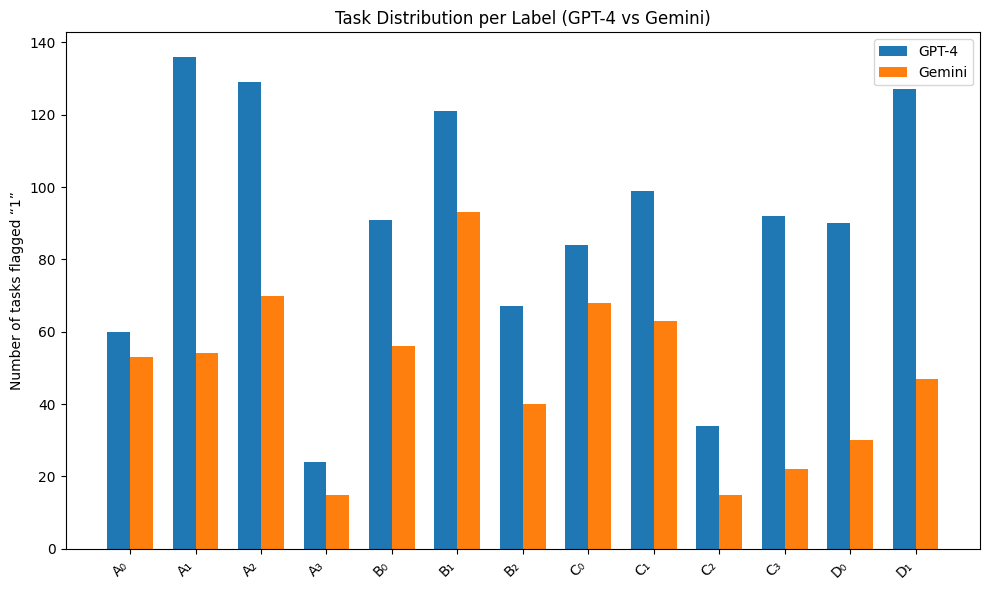

In [18]:
import json
import ast
from pathlib import Path
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1 - CONFIGURATION
# -------------------------------------------------
DATA_FILE = Path("annotation_results.json")  # Path to your JSON file

LABEL_NAMES = [
    "A₀", "A₁", "A₂", "A₃",   # first sublist (len 4)
    "B₀", "B₁", "B₂",         # second sublist (len 3)
    "C₀", "C₁", "C₂", "C₃",   # third sublist (len 4)
    "D₀", "D₁"                # fourth sublist (len 2)
]
N_LABELS = len(LABEL_NAMES)
assert N_LABELS == 13, "Must have exactly 13 label names"

# -------------------------------------------------
# 2 - SMART FLATTENING FUNCTION
# -------------------------------------------------
def to_flat(x):
    """
    Take x, which might be:
      - a JSON-style string '"[[0,1],[1,0]]"'
      - a Python-style literal string "'[[0,1],[1,0]]'"
      - an actual list-of-lists
      - a bare int
    and return a flat list of ints.
    """
    # If it's already a Python object
    if isinstance(x, list):
        nested = x
    elif isinstance(x, str):
        s = x.strip()
        # try JSON
        try:
            nested = json.loads(s)
        except json.JSONDecodeError:
            # fallback to Python literal
            nested = ast.literal_eval(s)
    else:
        # e.g. x is int
        nested = [x]

    # now flatten, treating any non-list as single element
    flat = []
    for item in nested:
        if isinstance(item, list):
            flat.extend(item)
        else:
            flat.append(item)

    # ensure correct length
    if len(flat) < N_LABELS:
        flat = flat + [0] * (N_LABELS - len(flat))
    elif len(flat) > N_LABELS:
        flat = flat[:N_LABELS]

    return list(map(int, flat))

# -------------------------------------------------
# 3 - LOAD & COUNT
# -------------------------------------------------
with DATA_FILE.open() as f:
    data = json.load(f)

gpt_counts    = np.zeros(N_LABELS, dtype=int)
gemini_counts = np.zeros(N_LABELS, dtype=int)

for rec in data.values():
    gpt_vec    = to_flat(rec.get("gpt_output", 0))
    gemini_vec = to_flat(rec.get("gemini_output", 0))
    gpt_counts    += np.array(gpt_vec,    dtype=int)
    gemini_counts += np.array(gemini_vec, dtype=int)

# -------------------------------------------------
# 4 - PLOT
# -------------------------------------------------
x     = np.arange(N_LABELS)
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, gpt_counts,    width, label="GPT-4")
ax.bar(x + width/2, gemini_counts, width, label="Gemini")

ax.set_ylabel("Number of tasks flagged “1”")
ax.set_title("Task Distribution per Label (GPT-4 vs Gemini)")
ax.set_xticks(x)
ax.set_xticklabels(LABEL_NAMES, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
# plt.savefig("task_distribution.png", dpi=300)  # uncomment to save
plt.show()


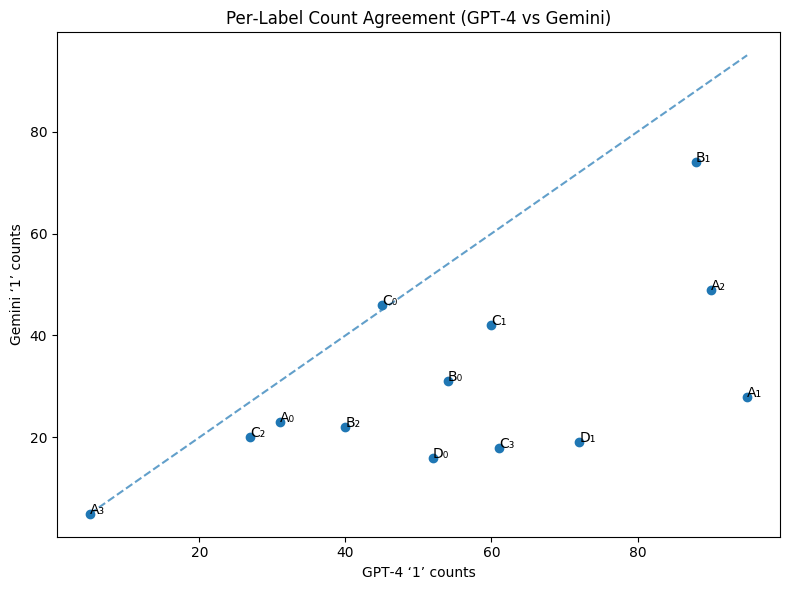

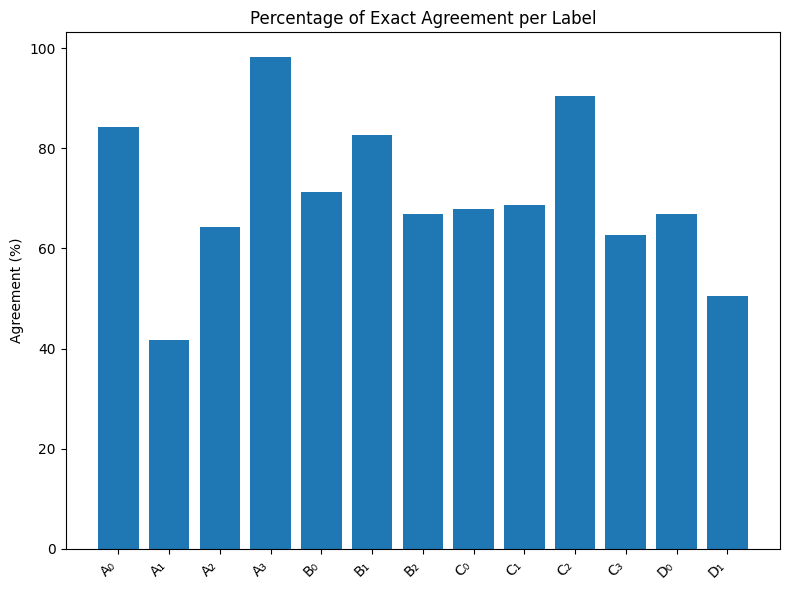

In [19]:
import json
import ast
from pathlib import Path
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1 – CONFIGURATION
# -------------------------------------------------
DATA_FILE = Path("annotation_results_new.json")  # adjust if your file is elsewhere

LABEL_NAMES = [
    "A₀", "A₁", "A₂", "A₃",  # first sublist (4)
    "B₀", "B₁", "B₂",        # second sublist (3)
    "C₀", "C₁", "C₂", "C₃",  # third sublist (4)
    "D₀", "D₁"               # fourth sublist (2)
]
N_LABELS = len(LABEL_NAMES)

# -------------------------------------------------
# 2 – SMART FLATTENING FUNCTION
# -------------------------------------------------
def to_flat(x):
    """
    Take x (JSON/Python-literal string, list, or int) and return
    a flat list of length N_LABELS, padding/truncating as needed.
    """
    # parse to nested
    if isinstance(x, list):
        nested = x
    elif isinstance(x, str):
        s = x.strip()
        try:
            nested = json.loads(s)
        except json.JSONDecodeError:
            nested = ast.literal_eval(s)
    else:
        nested = [x]

    # flatten
    flat = []
    for item in nested:
        if isinstance(item, list):
            flat.extend(item)
        else:
            flat.append(item)

    # enforce length
    if len(flat) < N_LABELS:
        flat += [0] * (N_LABELS - len(flat))
    else:
        flat = flat[:N_LABELS]

    return list(map(int, flat))

# -------------------------------------------------
# 3 – LOAD & BUILD MATRICES
# -------------------------------------------------
with DATA_FILE.open() as f:
    data = json.load(f)

gpt_matrix    = []
gemini_matrix = []

for rec in data.values():
    gpt_matrix.append(   to_flat(rec.get("gpt_output", 0))    )
    gemini_matrix.append(to_flat(rec.get("gemini_output", 0)) )

gpt_matrix    = np.array(gpt_matrix)
gemini_matrix = np.array(gemini_matrix)

# -------------------------------------------------
# 4 – VISUALIZATION
# -------------------------------------------------

# 4a: Scatter of total “1” counts per label
gpt_counts    = gpt_matrix.sum(axis=0)
gemini_counts = gemini_matrix.sum(axis=0)
x_vals        = np.arange(N_LABELS)
minv, maxv    = np.min([gpt_counts, gemini_counts]), np.max([gpt_counts, gemini_counts])

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(gpt_counts, gemini_counts)
ax.plot([minv, maxv], [minv, maxv], linestyle="--", alpha=0.7)
for i, lbl in enumerate(LABEL_NAMES):
    ax.annotate(lbl, (gpt_counts[i], gemini_counts[i]))
ax.set_xlabel("GPT‑4 ‘1’ counts")
ax.set_ylabel("Gemini ‘1’ counts")
ax.set_title("Per‑Label Count Agreement (GPT‑4 vs Gemini)")
plt.tight_layout()
plt.show()

# 4b: Percentage agreement per label
# (both models have the same bit, whether 0 or 1)
agreement_pct = (gpt_matrix == gemini_matrix).sum(axis=0) / gpt_matrix.shape[0] * 100

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x_vals, agreement_pct)
ax.set_xticks(x_vals)
ax.set_xticklabels(LABEL_NAMES, rotation=45, ha="right")
ax.set_ylabel("Agreement (%)")
ax.set_title("Percentage of Exact Agreement per Label")
plt.tight_layout()
plt.show()


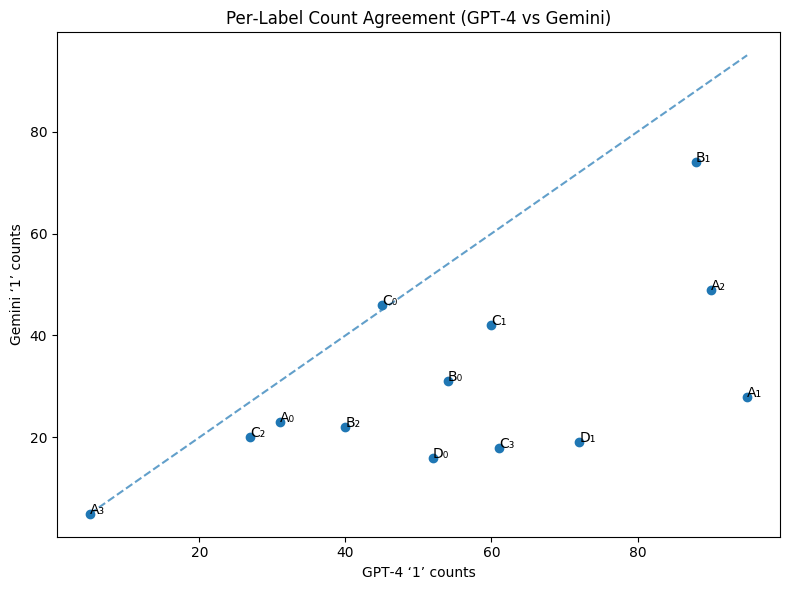

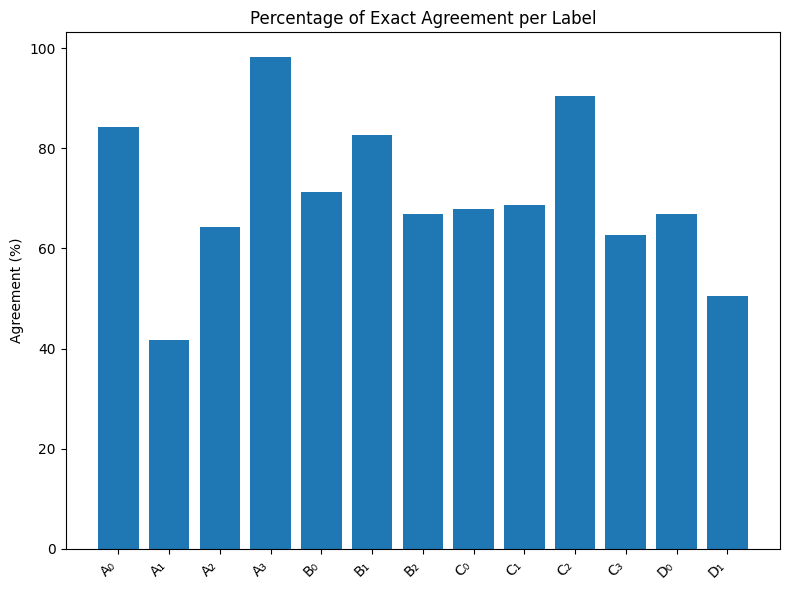


Cohen’s Kappa per Label:

Label  Cohen’s Kappa
   A₀       0.567308
   A₁       0.126912
   A₂       0.341940
   A₃       0.790909
   B₀       0.409522
   B₁       0.589725
   B₂       0.186220
   C₀       0.327273
   C₁       0.381166
   C₂       0.707514
   C₃       0.282189
   D₀       0.290123
   D₁       0.151895


In [20]:
import json
import ast
from pathlib import Path
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

# -------------------
# CONFIGURATION
# -------------------
DATA_FILE = Path("annotation_results_new.json")  # adjust if your file is elsewhere
LABEL_NAMES = [
    "A₀", "A₁", "A₂", "A₃",  # first sublist (4)
    "B₀", "B₁", "B₂",        # second sublist (3)
    "C₀", "C₁", "C₂", "C₃",  # third sublist (4)
    "D₀", "D₁"               # fourth sublist (2)
]
N_LABELS = len(LABEL_NAMES)

# -------------------
# FLATTENING FUNCTION
# -------------------
def to_flat(x):
    if isinstance(x, list):
        nested = x
    elif isinstance(x, str):
        s = x.strip()
        try:
            nested = json.loads(s)
        except json.JSONDecodeError:
            nested = ast.literal_eval(s)
    else:
        nested = [x]

    flat = []
    for item in nested:
        if isinstance(item, list):
            flat.extend(item)
        else:
            flat.append(item)

    # pad or truncate
    if len(flat) < N_LABELS:
        flat += [0] * (N_LABELS - len(flat))
    else:
        flat = flat[:N_LABELS]

    return list(map(int, flat))

# -------------------
# LOAD & BUILD MATRICES
# -------------------
with DATA_FILE.open() as f:
    data = json.load(f)

gpt_matrix    = []
gemini_matrix = []
for rec in data.values():
    gpt_matrix.append(to_flat(rec.get("gpt_output", 0)))
    gemini_matrix.append(to_flat(rec.get("gemini_output", 0)))

gpt_matrix    = np.array(gpt_matrix)
gemini_matrix = np.array(gemini_matrix)

# -------------------
# PLOT AGREEMENT VISUALS
# -------------------
# 1) Scatter of total “1” counts per label
gpt_counts    = gpt_matrix.sum(axis=0)
gemini_counts = gemini_matrix.sum(axis=0)
x_vals        = np.arange(N_LABELS)
minv, maxv    = min(gpt_counts.min(), gemini_counts.min()), max(gpt_counts.max(), gemini_counts.max())

plt.figure(figsize=(8,6))
plt.scatter(gpt_counts, gemini_counts)
plt.plot([minv, maxv], [minv, maxv], '--', alpha=0.7)
for i, lbl in enumerate(LABEL_NAMES):
    plt.text(gpt_counts[i], gemini_counts[i], lbl)
plt.xlabel("GPT‑4 ‘1’ counts")
plt.ylabel("Gemini ‘1’ counts")
plt.title("Per‑Label Count Agreement (GPT‑4 vs Gemini)")
plt.tight_layout()
plt.show()

# 2) Percentage exact agreement per label
agreement_pct = (gpt_matrix == gemini_matrix).sum(axis=0) / gpt_matrix.shape[0] * 100

plt.figure(figsize=(8,6))
plt.bar(x_vals, agreement_pct)
plt.xticks(x_vals, LABEL_NAMES, rotation=45, ha="right")
plt.ylabel("Agreement (%)")
plt.title("Percentage of Exact Agreement per Label")
plt.tight_layout()
plt.show()

# -------------------
# 3) COHEN’S KAPPA TABLE
# -------------------
kappas = [cohen_kappa_score(gpt_matrix[:, i], gemini_matrix[:, i]) 
          for i in range(N_LABELS)]

df_kappa = pd.DataFrame({
    "Label": LABEL_NAMES,
    "Cohen’s Kappa": kappas
})

print("\nCohen’s Kappa per Label:\n")
print(df_kappa.to_string(index=False))


In [21]:
import json
import ast
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    hamming_loss,
    jaccard_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    matthews_corrcoef
)

# -----------------------
# CONFIGURATION
# -----------------------
DATA_FILE = Path("annotation_results_new.json")  # adjust path if needed

LABEL_NAMES = [
    "A₀", "A₁", "A₂", "A₃",
    "B₀", "B₁", "B₂",
    "C₀", "C₁", "C₂", "C₃",
    "D₀", "D₁"
]
N_LABELS = len(LABEL_NAMES)

# -----------------------
# FLATTENING FUNCTION
# -----------------------
def to_flat(x):
    """
    Accepts:
      - JSON-string of list-of-lists,
      - Python-literal string,
      - actual list-of-lists, or
      - bare int
    Flattens and pads/truncates to length N_LABELS.
    """
    # parse into nested structure
    if isinstance(x, list):
        nested = x
    elif isinstance(x, str):
        s = x.strip()
        try:
            nested = json.loads(s)
        except json.JSONDecodeError:
            nested = ast.literal_eval(s)
    else:
        nested = [x]

    # flatten one level
    flat = []
    for item in nested:
        if isinstance(item, list):
            flat.extend(item)
        else:
            flat.append(item)

    # ensure correct length
    if len(flat) < N_LABELS:
        flat += [0] * (N_LABELS - len(flat))
    else:
        flat = flat[:N_LABELS]

    return list(map(int, flat))

# -----------------------
# LOAD DATA
# -----------------------
with DATA_FILE.open() as f:
    raw = json.load(f)

gpt_matrix = []
gemini_matrix = []

for rec in raw.values():
    gpt_matrix.append(   to_flat(rec.get("gpt_output", 0))    )
    gemini_matrix.append(to_flat(rec.get("gemini_output", 0)) )

gpt_matrix    = np.array(gpt_matrix)
gemini_matrix = np.array(gemini_matrix)

# -----------------------
# GLOBAL AGREEMENT METRICS
# -----------------------
subset_acc      = accuracy_score(gpt_matrix, gemini_matrix)
hl              = hamming_loss(gpt_matrix, gemini_matrix)
hamming_score   = 1 - hl
jaccard_samples = jaccard_score(gpt_matrix, gemini_matrix, average='samples')

precision_micro = precision_score(gpt_matrix, gemini_matrix, average='micro', zero_division=0)
recall_micro    = recall_score(gpt_matrix, gemini_matrix, average='micro', zero_division=0)
f1_micro        = f1_score(gpt_matrix, gemini_matrix, average='micro', zero_division=0)

precision_macro = precision_score(gpt_matrix, gemini_matrix, average='macro', zero_division=0)
recall_macro    = recall_score(gpt_matrix, gemini_matrix, average='macro', zero_division=0)
f1_macro        = f1_score(gpt_matrix, gemini_matrix, average='macro', zero_division=0)

df_global = pd.DataFrame({
    "Metric": [
        "Exact‑match accuracy",
        "Hamming loss",
        "Hamming score",
        "Average Jaccard (samples)",
        "Precision (micro)",
        "Recall (micro)",
        "F1 (micro)",
        "Precision (macro)",
        "Recall (macro)",
        "F1 (macro)"
    ],
    "Value": [
        subset_acc,
        hl,
        hamming_score,
        jaccard_samples,
        precision_micro,
        recall_micro,
        f1_micro,
        precision_macro,
        recall_macro,
        f1_macro
    ]
})

# -----------------------
# PER‑LABEL AGREEMENT METRICS
# -----------------------
kappas     = [cohen_kappa_score(gpt_matrix[:, i], gemini_matrix[:, i]) for i in range(N_LABELS)]
mccs       = [matthews_corrcoef(gpt_matrix[:, i], gemini_matrix[:, i]) for i in range(N_LABELS)]
precisions = precision_score(gpt_matrix, gemini_matrix, average=None, zero_division=0)
recalls    = recall_score(gpt_matrix, gemini_matrix, average=None, zero_division=0)
f1s        = f1_score(gpt_matrix, gemini_matrix, average=None, zero_division=0)

df_per_label = pd.DataFrame({
    "Label":          LABEL_NAMES,
    "Cohen’s Kappa":  kappas,
    "Matthews CC":    mccs,
    "Precision":      precisions,
    "Recall":         recalls,
    "F1":             f1s
})

# -----------------------
# OUTPUT RESULTS
# -----------------------
print("\n=== Global Agreement Metrics ===\n")
print(df_global.to_string(index=False))

print("\n=== Per‑Label Agreement Metrics ===\n")
print(df_per_label.to_string(index=False))



=== Global Agreement Metrics ===

                   Metric    Value
     Exact‑match accuracy 0.130435
             Hamming loss 0.294983
            Hamming score 0.705017
Average Jaccard (samples) 0.369489
        Precision (micro) 0.854962
           Recall (micro) 0.466667
               F1 (micro) 0.603774
        Precision (macro) 0.848549
           Recall (macro) 0.495727
               F1 (macro) 0.598409

=== Per‑Label Agreement Metrics ===

Label  Cohen’s Kappa  Matthews CC  Precision   Recall       F1
   A₀       0.567308     0.578098   0.782609 0.580645 0.666667
   A₁       0.126912     0.260299   1.000000 0.294737 0.455285
   A₂       0.341940     0.454124   1.000000 0.544444 0.705036
   A₃       0.790909     0.790909   0.800000 0.800000 0.800000
   B₀       0.409522     0.449338   0.838710 0.481481 0.611765
   B₁       0.589725     0.615661   0.959459 0.806818 0.876543
   B₂       0.186220     0.201816   0.545455 0.300000 0.387097
   C₀       0.327273     0.327327   0.

/Users/ankit.aich/miniconda3/envs/llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
len(list(data.keys()))

115